как работать с моделью YOLOv8 на низком уровне, без PyTorch и официального API. Это откроет массу новых возможностей для развертывания. Используя концепции и примеры из этого поста, вы сможете создать сервисы обнаружения объектов на основе искусственного интеллекта, которые используют в десять раз меньше ресурсов, и вы сможете создавать эти сервисы не только на Python, но и на большинстве других языков программирования. В частности, я покажу, как создать веб-сервис на базе YOLOv8 на Julia, Node.js, JavaScript, Go и Rust.

YOLOv8 deployment options
Нейронная сеть YOLOv8, изначально созданная с помощью фреймворка PyTorch и экспортированная в виде набора файлов «.pt».
Мы использовали Ultralytics API для обучения этих моделей или составления прогнозов на их основе. Для их запуска требуется среда с Python и PyTorch.

PyTorch — это отличная платформа для разработки, обучения и оценки моделей нейронных сетей. 
Кроме того, в нем есть инструменты для подготовки или даже генерации наборов данных для обучения моделей и многие другие полезные утилиты. 
Однако в производстве все это нам не нужно. Если говорить о YOLOv8, то все, что вам нужно в продакшене, это запустить модель с входным изображением и получить результирующие ограничивающие рамки. Тем не менее, YOLOv8 реализован на Python. Означает ли это, что все программисты, которые хотят использовать этот замечательный детектор объектов, должны стать программистами на Python? Означает ли это, что они должны переписать свои приложения на Python или интегрировать их с кодом Python? К счастью, нет. Ultralytics API имеет отличную функцию export для преобразования любой модели YOLOv8 в формат, который может быть использован внешними приложениями.

На данный момент поддерживаются следующие форматы:nt
TorchScr  ipt	torchscript
O        NNX	onnx
Open    VINO	openvino
Ten    sorRT	engine
        CoreML	coreml
TF SavedModel	saved_model
TF  GraphDef	p     b
TF Lite	tflite
T    F Edge TPU	edg        etpu
TF.js	tfjs
PaddlePaddle	paddle

Например, CoreML это формат нейронной сети, который можно использовать в iOS-приложениях, работающих на iPhone. .

Наиболее интересным из них для нас на сегодняшний день является ONNX — облегченная среда выполнения, созданная Microsoft, которая может быть использована для запуска моделей нейронных сетей на широком спектре платформ и языков программирования. Это не фреймворк, а просто разделяемая библиотека, написанная на C. Его размер составляет всего 16 МБ для Linux, но он имеет привязки интерфейсов для большинства языков программирования, включая Python, PHP, JavaScript, Node.js, C++, Go и Rust. Он имеет простой API и если вы написали ONNX-код для запуска модели на одном языке программирования, то не составит труда переписать его и использовать на другом, что мы сегодня и увидим.

Export YOLOv8 model to ONNX
Во-первых, давайте загрузим модель YOLOv8 и экспортируем ее в формат ONNX, чтобы сделать ее пригодной для использования.

In [1]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")
model.export(format="onnx")

/home/w111/anaconda3/envs/onnx390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:07<00:00, 6.79MB/s]


Ultralytics YOLOv8.0.235 🚀 Python-3.9.18 torch-1.8.1+cu102 CPU (Intel Celeron 2.80GHz)


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 6.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.8 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 47.2s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.15.0 opset 12...
ONNX: export success ✅ 227.5s, saved as 'yolov8m.onnx' (98.9 MB)

Export complete (538.2s)
Results saved to /home/w111/jupyternotebook
Predict:         yolo predict task=detect model=yolov8m.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8m.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.ap

'yolov8m.onnx'

В приведенном выше коде вы загрузили модель YOLOv8 среднего размера для обнаружения объектов и экспортировали ее в формат ONNX. Эта модель предварительно обучена на наборе данных COCO и может обнаруживать 80 классов объектов.

После выполнения этого кода вы должны увидеть экспортированную модель в файле с тем же именем и расширени onnxем. В этом случае вы увидите фа yolov8m.onnxйл в папке, в которой вы запустите этот коnx

Прежде чем писать веб-службу на основе ONNX, давайте узнаем, как эта библиотека работает в Jupyter Notebook, чтобы понять основные понятия.тия.

Изучение обнаружения объектов на изображении с помощью ONNX
Теперь, когда у вас есть модель, давайте использовать ONNX для работы с ней. Для простоты мы начнем с Python, потому что у нас уже есть веб-приложение Python, использующее API PyTorch и Ultralytics. Таким образом, будет проще переместить его в ONNX.

In [1]:
import onnxruntime as ort

Мы установили псевдоним ort для него. Запомните эту аббревиатуру ort, потому что в других языках программирования вы часто будете видеть вместо нее в среде выполнения ONNX. 

Модуль ort является корнем API ONNX. Основным объектом этого API является InferenceSession, который используется для создания экземпляра модели для выполнения прогнозирования на ней. Создание экземпляра модели работает очень похоже на Ultralytics

In [2]:
model = ort.InferenceSession("yolov8m.onnx", providers=['CPUExecutionProvider'])

Здесь мы загрузили модель, но из файла ".onnx" вместо ".pt". И теперь он готов к запуску.

И на этом сходство между Ultralytics и ONNX заканчивается. Если вы помните, с Ultralytics вы просто запустил outputs = model.predict("image_file")и: и получили результа
. Метод интеллектуального прогнозирования автоматически выполнил следующие действи")1. 

Чтение изображения из фа2. йла
Преобразуем его в формат входного слоя нейронной сети YO3. LOv8
Пропустите его через м4. одель
Получение необработанных выходных данных 5. модели
Синтаксический анализ необработанных выходных данных6.  модели
Возвращает структурированную информацию об обнаруженных объектах и их ограничивающих прямоу
   гольниках
Объект сеанса ONNX имеет аналоги runчный метод, но он реализует только шаги 3 и 4. Все остальное зависит от вас, потому что ONNX не знает, что это модель YOLOv8. Она не знает, какие входные данные ожидает получить эта нейронная сеть и что означают необработанные выходные данные этой модели. Это универсальный API для любого вида нейронных сетей, он не знает о конкретных вариантах использования, таких как обнаружение объектов на изожениях.run

С точки зрения ONNX, нейронная сеть — это черный ящик, который получает многомерный массив чисел с плавающей запятой в качестве входных данных и преобразует его в другой многомерный массив чисел. Какие числа должны быть на входе и что означают цифры на выходе, он не знает. Итак, и что мы можем с этим сделать?

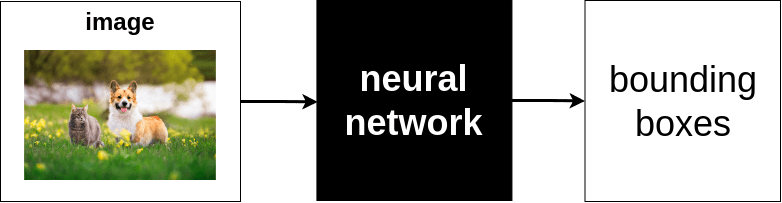

К счастью, все не так плохо, и мы можем это исследовать. Формы входного и выходного слоев нейронной сети фиксированы, они определяются при создании нейронной сети и наличии информации о них в модели.

Объект сеанса ONNX имеет полезный мет get_inputs()од для получения сведений о входных данных, которые эта модель ожидает получить, get_outputs() и для получения сведений о выходных данных, которые модель возвращает после обработки входных данны()

Давайте сначала получим входные данные:

In [3]:
inputs = model.get_inputs();
len(inputs)

1

Здесь мы получили массив входных данных и отобразили длину этого массива. 
Результат очевиден: сеть рассчитывает получить один вход. 
Давайте разберемся:

In [4]:
input = inputs[0]

Объект ввода имеет три поля: name,types и shape. Давайте получим эти значения для нашей модели YOLOv8:

In [5]:
print("Name:",input.name)
print("Type:",input.type)
print("Shape:",input.shape)

Name: images
Type: tensor(float)
Shape: [1, 3, 640, 640]


Вот что мы можем узнать из этого:
1. 
Название ожидаемых входных данных очевидно
   . Модель YOLOv8 получает изображения в качестве входных данн ыхimage2. s
Тип входных данныхtensor of float numbers — . Тензор может иметь множество определений, но с практической точки зрения, которая важна для нас сейч
   с, э  то многомерный массив чисел, массив чисел с плавающей запят
   й. Таким образом, мы можем сделать вывод, что нам нужно преобразовать наше изображение в многомерный массив чисел с плавающей запятe3. rs
На рисунке показаны размеры этого тензора. Здесь вы видите, что этот массив должен быть четырехмер
   ым. Это должно быть одно изображение (1), содержащее 3 матрицы с числами с плавающей запятой 640x
   40. Какие числа должны быть в этих матрицах? Матрица цветовых компонентов. Как вы должны знать, каждый цветной пиксель имеет крас
   ую, зеленую и синюю составляющие. Каждый компонент цвета может иметь значения от 0 до 
   55. Кроме того, вы можете сделать вывод, что изображение должно иметь размер 640x
   40. В итоге должно получиться 3 матрицы: одна матрица 640х640, содержащая красную составляющую каждого пикселя, одну для зеленой и одну для си
   ней.
Теперь у вас достаточно наблюдений, чтобы понять, что нужно сделать в коде для подготовки входных даых.



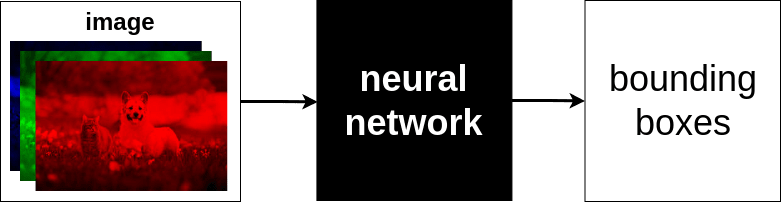

Подготовьте входные данные
Нам нужно загрузить изображение, изменить его размер до 640x640, извлечь информацию о Красной, Зеленой и Синей составляющих каждого пикселя и построить 3 матрицы интенсивностей соответствующих цветов.

Давайте просто сделаем это с помощью пакета python Pilнен:

Для примера возьмем изображение cat_dog.jpg

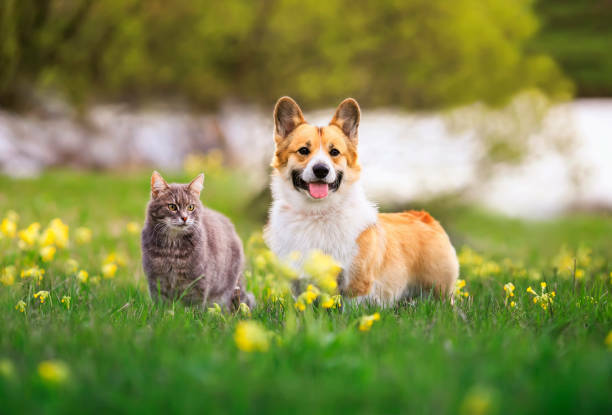

In [7]:
from PIL import Image

img = Image.open("cat_dog.jpg")
img_width, img_height = img.size;
img = img.resize((640,640))

Во-первых, мы загрузили объект Image из библиотеки Pillow. Затем мы создали объект img из файла cat_dog.jpg. Затем мы сохранили исходный размер изображения в переменные img_width и img_height, которые понадобятся позже. Наконец, мы изменили его размер, предоставив новый размер в виде кортежа (640 640).

Теперь нам нужно извлечь каждую цветовую составляющую каждого пикселя и построить из них 3 матрицы. Но тут у нас есть одна вещь, которая может привести к нестыковкам в будущем. Каждый пиксель имеет четыре цветовых канала: Красный, Зеленый, Синий и Альфа. Альфа-канал описывает прозрачность пикселя. Нам не нужен альфа-канал в изображении для предсказаний YOLOv8. Давайте удалим его:

In [8]:
img = img.convert("RGB")

По умолчанию изображение с альфа-каналом имеет цветовую модель "RGBA". С помощью этой строки мы преобразовали его в "RGB". 
Таким образом, мы удалили альфа-канал.

Теперь пришло время создать 3 матрицы значений цветового канала. Мы можем сделать это вручную, но Python имеет отличную совместимость между библиотеками. Библиотека NumPy, которая обычно работала с многомерными массивами, может просто загрузить объект изображения Pillow в виде массива следующим образом:

In [14]:
import numpy as np
input = np.array(img)
input.shape

(640, 640, 3)

Здесь мы импортировали NumPy и просто загрузили изображение в input массив NumPy. 

In [ ]:
Теперь нам небходимо переставить оси в нужном порядке:

In [15]:
input = input.transpose(2,0,1)
input.shape

(3, 640, 640)

Добавляем ещё одно измерение:

In [16]:
input = input.reshape(1,3,640,640)

Теперь у нас есть правильная входная форма. Мы можем увидеть содержимое этого массива, как, например, красную составляющую первого пикселя:

In [17]:
input[0,0,0,0]

71

Но нам требуются числа с плавающей запятой . Более того, как правило, числа для машинного обучения должны быть нормализованы в диапазоне от 0 до 1. Зная, что значение цвета может находиться в диапазоне от 0 до 255, мы можем масштабировать все пиксели до диапазона 0-1, если разделить их на 255. NumPy позволяет сделать это в одной строке кода:

In [18]:
input = input/255.0

In [19]:
input[0,0,0,0]

0.2784313725490196

В приведенном выше коде мы разделили все числа в массиве и отобразили первое из них: интенсивность компонента красного цвета для первого пикселя. 
Итак, вот так должны выглядеть входные данные.

Запуск модели
Теперь, прежде чем запускать процесс прогнозирования, давайте посмотрим, какой вывод должна вернуть модель YOLOv8. Как было сказано выше, это можно сделать с помощью метод get_outputs()а объекта сеанса ONNX. Результирующее значение этого метода имеет тот же тип, что и значениеget_inputs() , потому что, как я уже говорил: "единственная работа нейронной сети заключается в преобразовании одного массива чисел, предоставленного в качестве входных данных, в другой массив чисел". Итак, давайте посмотрим на вид выходных данных предварительно обученной модели YOLOv8)

In [20]:
outputs = model.get_outputs()
output = outputs[0]
print("Name:",output.name)
print("Type:",output.type)
print("Shape:",output.shape)

Name: output0
Type: tensor(float)
Shape: [1, 84, 8400]


ONNX — это универсальная платформа для запуска нейронных сетей любого типа. Поэтому он предполагает, что сеть может иметь много входов и много выходов, и принимает массив входов и массив выходов, даже если эти массивы имеют только один элемент. YOLOv8 имеет единственный выход, который является первым элементом объекта.outputs

Здесь вы видите, что у вывода есть и output0мя, он также имеет форму тензора чисел с плавающей запятой и форма этого вывода [1,84,8400], что означает, что это одна матрица 84x8400, вложенная в один массив. На практике это означает, что сеть YOLOv8 возвращает 8400 ограничивающих рамок и каждая ограничивающая рамка имеет 84 параметра. Немного некрасиво, что каждая ограничительная рамка здесь является столбцом, а не строкой. Это техническое требование нейросетевого алгоритма. Я думаю, что было бы лучше транспонировать его в 8400x84, чтобы было понятно, что есть 8400 строк, которые соответствуют обнаруженным объектам, и что каждая строка представляет собой ограничительную рамку с 84 параметрамt0

О том, почему для одной ограничительной рамки так много параметров, мы поговорим позже. Во-первых, мы должны запустить модель, чтобы получить данные для этого вывода. Сейчас у нас есть все для этого.

Чтобы запустить прогноз для модели YOLOv8, нам нужно выполнить run метод, который имеет следующую сигнатуру:

model.run(output_names,inputs)

1. output_names - массив имен выходов, которые мы хотим получить. В модели YOLOv8 это будет массив с одним элементом.2. 
inputs - словарь входных данных, которыймыы передёме в сеть в формате {name:tensor}, гдеname  - имя входных данных, аtensor  - массив данных изображения
    который мы подготовили ранееr

In [ ]:
Чтобы выполнить прогноз для подготовленных данных, можно выполнить следующую команду:

In [22]:
outputs = model.run(["output0"], {"images":input})
len(outputs)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Unexpected input data type. Actual: (tensor(double)) , expected: (tensor(float))

Если все прошло успешно, он отобразит, что длина полученного массива outputs равна 1, что означает, что у вас есть только один вывод. 
Однако, если вы получаете сообщение об ошибке о том, что входные данные должны быть в формате float, преобразуйте его в float32:

In [23]:
input = input.astype(np.float32)

In [24]:
outputs = model.run(["output0"], {"images":input})
len(outputs)

1

Тогда мы вплотную подошли к самой интересной части работы: обработать вывод.

Обработка выходных данных
Есть только один выход, поэтому мы можем извлечь его из выходов:

In [25]:
output = outputs[0]
output.shape

(1, 84, 8400)

Итак, как видите, он вернул на выход правильную форму. Так как в первом измерении есть только один элемент, мы можем просто получить его:

In [26]:
output = output[0]
output.shape

(84, 8400)

У нас получилась матрица с 84 строками и 8400 столбцами. Как я уже говорил, он имеет транспонированную форму, которая не очень подходит для работы, давайте транспонируем его еще раз:

In [27]:
output = output.transpose()

In [28]:
output.shape

(8400, 84)

Теперь понятнее: 8400 строк с 84 параметрами. 8400 — это максимальное количество ограничивающих рамок, которое может обнаружить модель YOLOv8, и она возвращает 8400 строк для любого изображения, независимо от того, сколько объектов на самом деле обнаружено на нем, потому что выходные данные нейронной сети фиксированы и определены во время проектирования нейронной сети. Она не может быть переменной. Таким образом, каждый раз он возвращает 8400 строк, но большинство из этих строк содержат просто мусор. Как определить, какие из этих строк содержат значимые данные, а какие являются мусором? Для этого нам нужно найти 84 параметра, которые есть в каждой из этих строк.

Первые 4 элемента являются координатами ограничивающего прямоугольника, а все остальные — вероятностями всех классов объектов, которые может обнаружить данная модель. Предварительно обученная модель, которую вы используете в этом руководстве, может обнаруживать 80 классов объектов, поэтому каждая ограничивающая рамка имеет 84 параметра: 4+80. Если использовать другую модель, которая, например, обучена детектировать 3 класса объектов, то она будет иметь 7 параметров подряд из-за 4+3.

Для примера отобразим номер строки 0:

In [29]:
row = output[0]
print(row)

[5.0601072e+00 8.4928741e+00 1.3374773e+01 1.8795433e+01 2.4437904e-06
 2.0861626e-07 5.6624413e-07 1.1920929e-07 2.0861626e-07 1.7881393e-07
 1.1920929e-07 1.7881393e-07 1.4901161e-07 2.9802322e-07 2.3841858e-07
 1.1920929e-07 1.7881393e-07 4.1723251e-07 5.0663948e-07 2.0861626e-07
 2.0861626e-07 2.0861626e-07 3.8743019e-07 2.6822090e-07 1.4901161e-07
 1.4901161e-07 3.8743019e-07 2.6822090e-07 2.6822090e-07 2.6822090e-07
 2.0861626e-07 2.3841858e-07 5.9604645e-08 2.0861626e-07 1.1920929e-07
 2.0861626e-07 3.8743019e-07 3.5762787e-07 1.1920929e-07 1.1920929e-07
 5.9604645e-08 2.0861626e-07 1.7881393e-07 2.0861626e-07 1.4901161e-07
 2.6822090e-07 4.1723251e-07 1.4901161e-07 1.4901161e-07 3.2782555e-07
 1.7881393e-06 6.8545341e-07 2.0861626e-07 4.4703484e-07 1.3113022e-06
 3.2782555e-07 2.0861626e-07 2.3841858e-07 4.7683716e-07 2.9802322e-07
 8.0466270e-07 1.4901161e-07 4.1723251e-07 1.7881393e-07 3.2782555e-07
 2.3841858e-07 1.7881393e-07 8.9406967e-08 1.1920929e-07 1.7881393e-07
 8.940

Здесь мы видим, что эта строка представляет собой ограничивающий прямоугольник
с координатами [5.0601072, 8.4928741, 13.374773, 18.795433]. 
Эти значения являются координатами центра этой ограничивающей рамки, шириной и высотой:

x_center  5.060107282
y_center 8.4928741662
wi   dt13.3747730.247
he  ig18.79543309.459

Давайте вырежем эти переменные из строки:

In [30]:
xc,yc,w,h = row[:4]

Все остальные значения являются вероятностями того, что обнаруженный объект принадлежит к каждому из 80 классов. 
Так, предполагая, что нумерация массива начинается с 0, 
элемент номер 4 содержит вероятность принадлежности объекта к классу 0 (2.4437904e-06), 
элемент номер 5 содержит вероятность принадлежности объекта к классу 1 (2.0861626e-07) и т.д.

Теперь давайте удалим весь мусор и разберем эту строку в формат [x1,y1,x2,y2,class_label,probability].

Для вычисления координат углов ограничительной рамки можно использовать следующие формулы:

x1 = xc-w/2
y1 = yc-h/2
x2 = xc+w/2
y2 = yc+h/2

Но есть очень важное напоминание: помните ли вы, что в начале мы масштабировали изображение до 640х640? Это означает, что эти координаты возвращаются в предположении, что изображение имеет этот размер. Чтобы получить координаты этого ограничительного прямоугольника для исходного изображения, нам нужно масштабировать их пропорционально размерам исходного изображения. Мы сохранили исходную ширину и высоту в переменные img_width и img_height, а чтобы масштабировать углы ограничительной рамки, нам нужно изменить формулы:

x1 = (xc - w/2) / 640 * img_width
y1 = (yc - h/2) / 640 * img_height
x2 = (xc + w/2) / 640 * img_width
y2 = (yc + h/2) / 640 * img_height

Тогда нужно найти объект с максимальной вероятностью. 
С одной стороны, это можно сделать в цикле, перебирая от 4 до 84 элементов этого массива 
и выбирая индекс элемента данных с максимальным значением вероятности, 
но в NumPy для этого есть удобные методы:

In [31]:
prob = row[4:].max()
class_id = row[4:].argmax()

print(prob, class_id)

2.4437904e-06 0


Первая строка возвращает максимальное значение подмассива от 4 до конца строки. Вторая строка возвращает индекс элемента с этим максимальным значением. Итак, здесь вы видите, что первая вероятность имеет максимальное значение, а это значит, что эта ограничивающая рамка принадлежит классу 0.

Чтобы заменить идентификатор класса меткой класса, у вас должен быть массив классов, которые модель может прогнозировать. В случае с этой моделью это 80 классов из датасета COCO. Вот они:

In [32]:
yolo_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

В случае, если вы используете другую пользовательскую обученную модель, то вы можете получить этот массив из YAML-файла, который использовался для обучения. 

Тогда вы можете просто получить метку класса по идентификатору:

In [ ]:
label = yolo_classes[class_id]

Вот как мы должны анализировать каждую строку выходных данных модели YOLOv8.

Однако эта вероятность слишком мала, потому что 2.4437904e-06 = 2.4437904 / 1000000 = 0.000002443. 
Так вот, эта ограничительная рамка, возможно, просто мусор, который следует отфильтровать. Я рекомендую отфильтровать все ограничивающие рамки с вероятностью менее 0.5.

Давайте напишем весь приведенный выше код синтаксического анализа строк в виде функции, чтобы разобрать любую строку следующим образом:

In [33]:
def parse_row(row):
    xc,yc,w,h = row[:4]
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    prob = row[4:].max()
    class_id = row[4:].argmax()
    label = yolo_classes[class_id]
    return [x1,y1,x2,y2,label,prob]

Теперь мы можем написать код, который анализирует и отфильтровывает все строки из вывода:

In [34]:
boxes = [row for row in [parse_row(row) for row in output] if row[5]>0.5]
len(boxes)

20

Здесь используется описания списков Python. Внутренний перечень:
[ parse_row(row) for row in output ]

используется для синтаксического анализа каждой строки и возвращает массив разобранных строк в
формате [x1,y1,x2,y2,class_id,prob].

а затем внешний список, используемый для фильтрации всех этих строк, если их вероятность меньше 
[row for row in [((parsed_rows))] in row[5]>0.5]0,5

После этого показывается len(boxes), что после фильтрации осталось только 20 рамок. 
Гораздо ближе к ожидаемому результату, чем 8400, но все равно это многовато, 
потому что у нас есть изображение только с одной кошкой и одной собакой. 
Любопытно, что еще обнаружено? Покажем эти данные:

In [ ]:
boxes

{
{261.26427698135376,  95.5394926071167,  461.0894476890564,  313.3424220085144,  'dog',  0.92236143],
{261.15139932632445,  95.61906313896179,  460.88843908309934,  313.9778583049774,  'dog',  0.9225557],
{261.00633344650265,  95.50790977478027,  460.879421710968,  313.72810459136963,  'dog',  0.92753756],
{260.76785459518436,  95.70947790145874,  461.3623326301575,  313.65912103652954,  'dog',  0.9271232],
{139.5701927661896,  169.41292476654053,  255.10676150321962,  314.7036895751953,  'cat',  0.89753526],
{139.54468002319337,  169.6348752975464,  255.03512592315673,  314.66233110427856,  'cat',  0.9049016],
{139.70241107940674,  169.57234287261963,  255.10101985931396,  315.04322481155396,  'cat',  0.8874236],
{261.1314239501953,  95.70264089107513,  461.01230392456057,  313.5303655862808,  'dog',  0.927495],
{260.9263298034668,  95.78038096427917,  460.94862785339353,  313.4921238422394,  'dog',  0.925281],
{260.47499427795407,  95.79308533668518,  461.3350032806396,  313.4893138408661,  'dog',  0.904428],
{139.61649799346924,  169.28671216964722,  255.25320625305176,  314.86817359924316,  'cat',  0.8796594],
{139.48031086921694,  169.37533605098724,  255.2633544445038,  314.8822532892227,  'cat',  0.87492824],
{139.6516044616699,  169.6540505886078,  255.4759265899658,  314.8605945110321,  'cat',  0.8614943],
{261.16974048614503,  95.69103479385376,  460.98099117279054,  313.100643157959,  'dog',  0.9220617],
{260.80802421569825,  95.74604749679565,  461.27068519592285,  313.3235831260681,  'dog',  0.9103928],
{260.49587430953983,  95.88908052444458,  461.28050508499143,  313.16998291015625,  'dog',  0.88568854],
{139.51894841194152,  169.38715982437134,  255.33520159721374,  314.8621973991394,  'cat',  0.83352244],
{139.56962370872498,  169.59248781204224,  255.60057206153868,  314.89215755462646,  'cat',  0.872819],
{139.67168197631835,  169.6206966638565,  255.7860191345215,  315.0896590948105,  'cat',  0.84732854],
{139.8815620422363,  169.39741039276123,  255.5758472442627,  314.7368950843811,  'cat',  0.82181823]
]

Все эти рамки имеют высокую вероятность и их координаты перекрывают друг друга. Давайте нарисуем эти прямоугольники на изображении, чтобы понять, почему это так.

В пакете есть модуль, который позволяет рисовать прямоугольники или другие фигуры поверх изображений. Давайте загрузим изображение с помощью этого объекта:

In [40]:
from PIL import ImageDraw, Image 

img = Image.open("cat_dog.jpg")
draw = ImageDraw.Draw(img)

и рисуем каждую ограничительную рамку на изображении, используя созданный объект draw в цикле:

Этот код рисует зеленые прямоугольники для каждой ограничительной рамки и отображает результирующее изображение, которое будет выглядеть следующим образом:

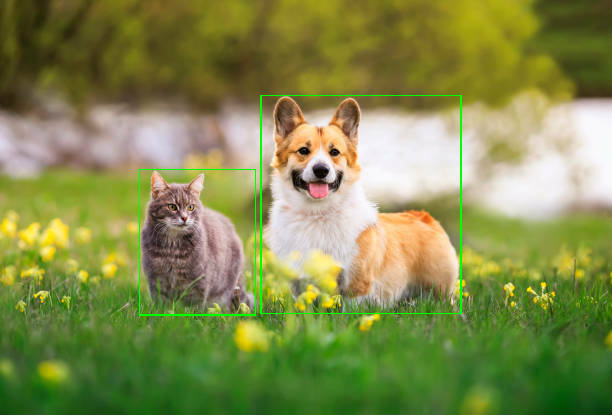

In [41]:
for box in boxes:
    x1,y1,x2,y2,class_id,prob = box
    draw.rectangle((x1,y1,x2,y2),None,"#00ff00")

img

Он рисует все эти 20 рамок друг на друге, так что они выглядят как просто 2 рамки. Как человек, вы можете видеть, что все эти 20 рамок принадлежат одним и тем же 2 объектам. Тем не менее, нейронная сеть не является человеком, и она считает, что нашла 20 разных кошек и собак, которые перекрывают друг друга, потому что теоретически возможно, что разные объекты на изображении могут перекрывать друг друга. Возможно, это звучит безумно, но именно так это работает.

Мы сами выбираем, какие из этих рамок должны остаться, а какие отфильтровать. Как это сделать? С одной стороны, мы можем выбрать рамку с наибольшей вероятностью для собаки и рамку с наибольшей вероятностью для кошки, а все остальные убрать. Тем не менее, это полезное решение не для всех случаев, потому что мы можем иметь изображения с несколькими собаками и несколькими кошками одновременно. Мы должны найти и использовать какой-то алгоритм общего назначения, который удаляет все блоки, которые тесно перекрывают друг друга. К счастью, этот алгоритм уже существует, и он называется Non-maximum suppression. Вот шаги, которые мы должны выполнить, чтобы это работало:

1. Создать пустой результирующий массив, который будет содержать список блоков, которые мы хотим сохранить.
2. Запуск цикла
3. Из массива исходных блоков выберать блок с наибольшей вероятностью и переместите его в результирующий массив.
4. Сравнить выбранный блок с другим блоком из исходного массива и удалить все, которые слишком сильно перекрывают выбранный.
5. Если исходный массив содержит больше блоков, перейти к шагу 2 и повторить
   
После завершения цикла массив source boxes будет пустым, а результирующий массив будет содержать только разные блоки. 
Теперь давайте разберемся, как реализовать шаг 4, как сравнить две коробки и обнаружить, что они слишком сильно перекрывают друг друга. 
Чтобы найти его, воспользуемся другим алгоритмом - "Пересечение над объединением" или IoU. Этот алгоритм на самом деле представляет собой формулу:

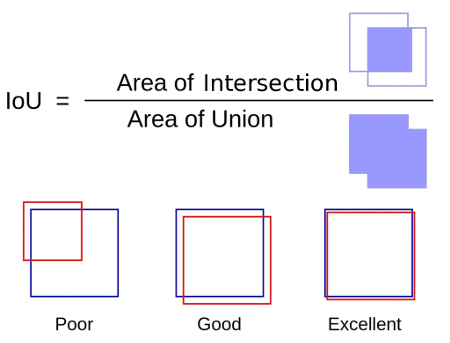

Идея этого алгоритма заключается в следующем:
1. Вычислить площадь пересечения двух рамок.
2. Рассчитайть площадь их объединения.
3. Разделить первое на второе.

Чем ближе результат к 1, тем больше два прямоугольника перекрывают друг друга. Это видно визуально: чем ближе область пересечения двух рамок к области их объединения, тем больше она похожа на одну и ту же рамку. В левом окошке под формулой эти рамки перекрывают друг друга, но не слишком сильно, и IoU в этом случае может быть около 0,3. Определенно, эти два прямоугольника можно рассматривать как разные объекты, даже если они перекрываются. На втором примере видно, что область пересечения гораздо ближе к области их объединения, возможно, IoU здесь будет около 0.8. Высока вероятность, что одну из этих рамок следует убрать. Наконец, прямоугольники на правом образце представляют собой почти ту же область, и определенно должна остаться только одна из них.

Теперь реализуем в коде как IoU, так и подавление Non-Maximum.

Пересечение над объединением
1 Вычислить площадь пересеченияn

In [42]:
def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1) 

Здесь мы вычисляем площадь прямоугольника пересечения, используя его ширину (x2-x1) и высоту (y2-y1).

2 Рассчитать площадь объединения

In [43]:
def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

3 Разделить первое на второе

In [44]:
def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

Non-maximum suppression

Итак, у нас есть массив блоков в переменной boxes, и нам нужно оставить в нем только разные элементы, используя созданную функцию iou в качестве критерия различия. 
Допустим, если IoU из двух рамок меньше 0,7, то они обе должны остаться. В противном случае одна из них с меньшей вероятностью должна уйти. 
Реализуем его:

In [45]:
boxes.sort(key=lambda x: x[5], reverse=True)
result = []
while len(boxes)>0:
    result.append(boxes[0])
    boxes = [box for box in boxes if iou(box,boxes[0])<0.7]

Для удобства в первой строке мы отсортировали все боксы по вероятности в обратном порядке, чтобы переместить рвмки с наибольшими вероятностями наверх.

Затем код определяет массив для результирующирамоков. В цикле он помещает пеую рамкуок (котаяый являетсрамкойом с наибольшей вероятностью) в результирующий массив, а в следующей строке перезаписывает массив boxes только темрамкамими, которые имеют 'IoU' с выбраой рамкойом, который меньше 0.7.

Он продолжает делать это в цикле до тех пор, пboxes ока не будет содержать элеменoxes

После его запуска можно распечатать массив:

In [46]:
print(result)

[[261.00633344650265, 95.50790977478027, 460.879421710968, 313.72810459136963, 'dog', 0.92753756], [139.54468002319337, 169.6348752975464, 255.03512592315673, 314.66233110427856, 'cat', 0.9049016]]


Теперь в нем всего 2 пункта, как и положено. Код проделал свою волшебную работу и отобрал лучшие рамки для кошки и собаки с наибольшей вероятностью.

И вот, наконец-томывы это сделали! Мно ы представить, сколько кодн вам пришлось написать вместо одной стро model.predict()ки в Ultralytics API? Однако теперь н вас есть знание того, как это работает на самом деле, и знание этих алгоритмов делаен вас независимым от среды PyTorch. Теперм вы момте создавать приложения, использующие модели YOLOv8, используя любой язык программирования, поддерживаемый ONNX, мы я покемам, как это сделат

В следующих разделах мы сделаем веб-службы обнаружения объектов, для использования ONNX вместо PyTorch. Мы напишем его на Python, Julia, Node.js, JavaScript, Go и Rust.

Первый раздел с Python определяет структуру проекта, функции и их отношения, а затем мы перепишем все эти функции на других языках программирования, не меняя структуру проекта.

Раздел Python рекомендуется для всех, замым вы мжете переходить к разделам, связанным с выбранами языком. Используя определенную структуру проекта и алгоритмы, вы смжете написать веб-сервис на любом другом языке, поддерживающем ONNX.

Я предполагаю, что вы знакомы со всеми языками, которые вы выбираете, и у вас есть все необходимые IDE и инструменты для написания, компиляции и запуска этого кода. Я остановлюсь только на ONNX и алгоритмах, описанных выше, и не буду учить вас программированию на этих языках. Кроме того, я не буду углубляться в их стандартные библиотеки. Тем не менее, я предоставлю ссылки на документацию по API всех внешних пакетов и фреймворков, которые мы будем использовать, и вы должны либо знать API этих библиотек, либо иметь возможность изучить их с помощью этой докумении.


()

Создание веб-сервиса на Python

Настройка проекта

В качестве основы мы будем использовать проект,  из этого репозитория.
https://github.com/AndreyGermanov/yolov8_pytorch_python

Создаём новую папку и копируем в нее следующие файлы из проекта:

index.html - Фронтенд
object_detector.py - бэкенд
requirements.txt - список внешних зависимостей
ткже скопируйте модель yolov8m.onnx ONNX, экспортированную в нт.onnx

Затываемткрой object_detector.pyте файл яем ultralyticsаимоonnxruntimeсть на . Кроме того, добавьт numpyе пакет в список. Он будет использоваться для преобразования изображения в м
ассив. Наконец, список завис requirements.txtимостей должен выглядеть следующим о

ultralytics
flask
waitress
pillow
numpymenumpy

Мы не будем менять фронтенд index.html, поэтому останеться прежнм. Единственный файл, который мы изменим, — это object_detector.py, в котором мы перепишем код обнаружения объектов, который ранее использовал API Ultralytics для использования среды выполнения ONNX.

Внесем несколько изменений в структуру этого файла:

import onnxruntime as ort
from flask import request, Flask, jsonify
from waitress import serve
from PIL import Image
import numpy as np
import json

app = Flask(__name__)


def main():
    serve(app, host='0.0.0.0', port=8080)


@app.route("/")
def root():
    with open("index.html") as file:
        return file.read()


@app.route("/detect", methods=["POST"])
def detect():
    buf = request.files["image_file"]
    boxes = detect_objects_on_image(buf.stream)
    return jsonify(boxes)


def detect_objects_on_image(buf):
    model = YOLO("best.pt")
    results = model.predict(buf)
    result = results[0]
    output = []
    for box in result.boxes:
        x1, y1, x2, y2 = [
            round(x) for x in box.xyxy[0].tolist()
        ]
        class_id = box.cls[0].item()
        prob = round(box.conf[0].item(), 2)
        output.append([
            x1, y1, x2, y2, result.names[class_id], prob
        ])
    return output


main()

Если сравнить этот листинг с оригинальным object_detector.py, то мы заменили пакет ultralytics на import onnxruntime as ort, которая импортирует среду выполнения ONNX: . Кроме того, импортировали numpy как np.

Затею код, который запускает веб-серве помещаемр, в функц mainию ставимаю его в начало. Наконеця возаю main() в качестве последней строкin

Мы не будем менять маршруты внутри функции main, поэтому функroot и detect and останутся прежними. Мы перепишем толdetect_objects_on_image ько среду выполнения ONNX вместо Ultralyt
cs. Реализация будет более сложной, чем сеаmage

Мы разделим функцию dected_objects_on_image на три части:
1. 
Подготитьте входные данны2. е
Запуск моде3. ли
Обработка выходных да
   нных
Каждую фазу мы будем помещать в отдельную функцию, которую вызовет вы
зов. Змените содержимое этой фу detect_objects_on_imageнкции на следуimage

def detect_objects_on_image(buf):
    input, img_width, img_height = prepare_input(buf)
    output = run_model(input)
    return process_output(output,img_width,img_height)

def prepare_input(buf):
    pass

def run_model(input):
    pass

def process_output(output,img_width,img_height):
    pass

1. В первой строке функция prepare_input получает содержимое загруженного файла, преобразует его в массив input и возвращает. Кроме того, он возвращает исходные размеры изображения: image_width и image_height, которые позже будут использоваться для масштабирования обнаруженных ограничивающих рамок.2. 
Затем функци run_modelя получае inputт и запускает сеанс ONNX с его помощью. Он возвращает масси outputв формы (1,84,8400)t3. 
Наконец, переданныoutput й в функц process_outputию вместе с исходным размером изображенияimg_width  img_height, ). Эта функция должна возвращать массив ограничивающих рамок. Каждый элемент этого массива имеет следующий формат{t[x1,y1,x2,y2,class_label,prob
]
Давайте напишем эти функции одну за друг




Подготовка входных данных

Функци prepare_inputя использует код, написанный в разделе Подготовка входных данных. Вот как это выглядитt

def prepare_input(buf):
    img = Image.open(buf)
    img_width, img_height = img.size
    img = img.resize((640, 640))
    img = img.convert("RGB")
    input = np.array(img)
    input = input.transpose(2, 0, 1)
    input = input.reshape(1, 3, 640, 640) / 255.0
    return input.astype(np.float32), img_width, img_height

1. Этот код загружает изображение, сохраняет его размер img_width и img_height.
2. Затем он изменяет его размер, удаляет прозрачность, преобразуя в RGB, и преобразует в тензор пикселей, загружая как np.array().
3. Затем он транспонирует и изменяет форму массива, чтобы преобразовать его из формы (640,640,3) в форму (1,3,640,640),
   делит все значения на 255.0, чтобы нормализовать его и сделать совместимым с форматом входных данных модели ONNX.
4. Наконец, он возвращает входной массив, преобразованный в тип данных "Float32" вместе с оригинальным img_width и img_height. Здесь важно выполнить преобразование в np.float32, так как по умолчанию Python использует double в качестве типа для чисел с плавающей запятой, но для модели среды выполнения ONNX требуется Float32.

Запуск модели

В этой функциимыы можме повторно использовать код, который мы написали в разделе Запуск модели.

def run_model(input):
    model = ort.InferenceSession("yolov8m.onnx", providers=['CPUExecutionProvider'])
    outputs = model.run(["output0"], {"images":input})
    return outputs[0]

Сначала мы загружаем модель из файла yolov8m.onnx, а затем используем метод run для обработки input и возврата выходных данных. 
Наконец, он возвращает первый вывод, который представляет собой массив (1,84,8400) формы.

Теперь пришло время обработать и преобразовать этот вывод в массив ограничивающих рамок.

Обработка выходных данных

Код для обработки выходных данных будет включать функции из раздела Обработка выходных данных для фильтрации всех перекрывающихся блоков с помощью алгоритма "Пересечение через объединение". Кроме того, он будет использовать массив классов YOLO для получения меток для каждого обнаруженного объекта. Этот код вы можете просто скопировать/вставить из соответствующих мест:

def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1)

yolo_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

Это функция iou и ее зависимости для вычисления intersection и union. Кроме того, существует массив классов YOLO, которые модель может обнаружить.

Теперь, имея все это, мы можем реализовать функцию process_output:

def process_output(output, img_width, img_height):
    output = output[0].astype(float)
    output = output.transpose()

    boxes = []
    for row in output:
        prob = row[4:].max()
        if prob < 0.5:
            continue
        class_id = row[4:].argmax()
        label = yolo_classes[class_id]
        xc, yc, w, h = row[:4]
        x1 = (xc - w/2) / 640 * img_width
        y1 = (yc - h/2) / 640 * img_height
        x2 = (xc + w/2) / 640 * img_width
        y2 = (yc + h/2) / 640 * img_height
        boxes.append([x1, y1, x2, y2, label, prob])

    boxes.sort(key=lambda x: x[5], reverse=True)
    result = []
    while len(boxes) > 0:
        result.append(boxes[0])
        boxes = [box for box in boxes if iou(box, boxes[0]) < 0.7]
    return result

1. Первые две строки преобразуют output из (1,84,8400) в (8400,84), что составляет 8400 строк с 84 столбцами. Кроме того, он преобразует значения массива из np.float32 в тип данных float.
   Это необходимо для того, чтобы сериализовать результат в JSON finally.2. 
Перыйяцикля используется для прохождения рядов. Для каждой строки вычисляется вероятность этого прогноза и пропускаются все строки, если вероятность меньше 0,5.3. 
Для строк, прошедших проверку вероятности, он определяет обнаруженный объекclass_id т labelст этого класса, используelyolo_class.e4. s
Затем он вычисляет угловые координаты ограничительной рамки, используя координаты ее центра, ширины и высоты. Кроме того, он масштабирует его до исходного размера изображе
   ия с помощью параметри .img_wi и dthimg_hei.g5. ht
Затем он добавляет вычисляемую ограничивающую рамку к мас иву.b.o6. xes
Последняя часть функции фильтрует обнаружеboxes нные с помощью алгоритма "Немаксимальное подавление". Он фильтрует все блоки, которые перекрывают блок с наибольшей вероятно
   тью, используя фунiou кцию для определения значения перекрывающегося критe7. siou
Наконец, все блоки, прошедшие фильтр, воютсящались в виде м ссива..
   result
Вот и все для реализации на  образом:

Если все реализовано без ошибок, вы можете запустить этот веб-сервис следующим образом:

python object_detector.py

In [56]:
%cd ./onnx_web


/home/w111/jupyternotebook/onnx_web


/home/w111/anaconda3/envs/onnx390/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [57]:
!python object_detector.py

^C


затем открыть http://localhost:8080 в веб-браузере, и он должен работать точно так же, как и оригинальный сервис, реализованный с помощью версии PyTorch модели YOLOv8.

Среда выполнения ONNX является низкоуровневой библиотекой, поэтому для работы модели требуется гораздо больше кода, однако решение, созданное таким образом, лучше развертывать в рабочей среде, так как оно требует в 10 раз меньше места на жестком диске.b.



Первоисточник:
https://dev.to/andreygermanov/how-to-create-yolov8-based-object-detection-web-service-using-python-julia-nodejs-javascript-go-and-rust-4o8e